<a href="https://colab.research.google.com/github/MartaGacek1/MonteCarloProject2/blob/main/MonteCarloProjekt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt II - Wprowadzenie do symulacji i metod Monte Carlo

## Marta Gacek

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import time
import math

np.random.seed(123)

S_0 = 100
K = 100
r = 0.05
sigma = 0.25
R = 100000

## 1. Prawdziwa wartość opcji

Ta wartość zostanie wykorzystana do porównywania wyników w przypadkach gdy $n=1$ dla różnych estymatorów.

In [2]:
d1 = (np.log(S_0/K) + r + sigma**2/2)/sigma
d2 = d1 - sigma
real = S_0 * sc.stats.norm.cdf(d1) - K * np.exp(-r) * sc.stats.norm.cdf(d2)
print(real)

12.335998930368717


## 2. Crude Monte Carlo Estimator

### Przypadek $n=1$

In [3]:
import numpy as np

start_time = time.time()

z = np.random.normal(0, 1, R)  # zmienne z rozkładu standardowego normalnego
S_T = S_0 * np.exp(r - (sigma**2)/2 + sigma * z)  # geometryczny ruch Browna
y = np.maximum(S_T - K, 0)
est_I = np.exp(-r) * np.mean(y)

print(f"Estymowana wartość opcji dla n=1 to: {est_I:.4f}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=1 to: 12.3620
Czas wykonania: 0.014682 sekund


In [4]:
# Przedział ufności

alpha = 0.05
sig = np.var(y)
left = est_I - (sc.stats.norm.ppf(1-alpha/2) * np.sqrt(sig)/np.sqrt(R))
right = est_I + (sc.stats.norm.ppf(1-alpha/2) * np.sqrt(sig)/np.sqrt(R))
conf_interval = [left, right]
print(conf_interval)
print(f"Szerokość przedziału ufności: {right-left:.4f}")

[12.241388377432854, 12.482647664847947]
Szerokość przedziału ufności: 0.2413


In [5]:
# Błąd bezwzględny

error = np.abs(est_I - real)
print(f"Błąd bezwzględny: {error:.4f}")

Błąd bezwzględny: 0.0260


### Przypadek $n > 1$

In [29]:
n1 = 2
n2 = 2**2
n3 = 2**4
n4 = 2**6
n5 = 2**8
n6 = 2**10

ests = []

def est(n, S_0 = 100, K = 100, r = 0.05, sigma = 0.25, R = 100000):
  step = 1/n
  z = np.random.normal(0, 1, (R, n))
  prices = np.zeros((R, n))
  prices[:, 0] = S_0
  for t in range(1, n):
    prices[:, t] = prices[:, t-1] * np.exp((r - sigma**2/2) * step + sigma * np.sqrt(step) * z[:, t-1])  # geometryczny ruch Browna
  A_n = np.mean(prices, axis=1)
  y = np.maximum(A_n - K, 0)
  est_I = np.exp(-r) * np.mean(y)
  ests.append(est_I)
  print(f"Estymowana wartość opcji dla n={n} wynosi: {est_I:.4f}")

In [30]:
start_time = time.time()
print(est(n1))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=2 wynosi: 4.0082
None
Czas wykonania: 0.026139 sekund


In [31]:
start_time = time.time()
print(est(n2))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=4 wynosi: 5.4600
None
Czas wykonania: 0.027267 sekund


In [32]:
start_time = time.time()
print(est(n3))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=16 wynosi: 6.5178
None
Czas wykonania: 0.143281 sekund


In [33]:
start_time = time.time()
print(est(n4))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=64 wynosi: 6.7704
None
Czas wykonania: 0.630489 sekund


In [34]:
start_time = time.time()
print(est(n5))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=256 wynosi: 6.8680
None
Czas wykonania: 3.010979 sekund


In [35]:
start_time = time.time()
print(est(n6))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Estymowana wartość opcji dla n=1024 wynosi: 6.8689
None
Czas wykonania: 14.996636 sekund


Text(0.5, 1.0, 'Crude Monte Carlo Estimator results for n>1')

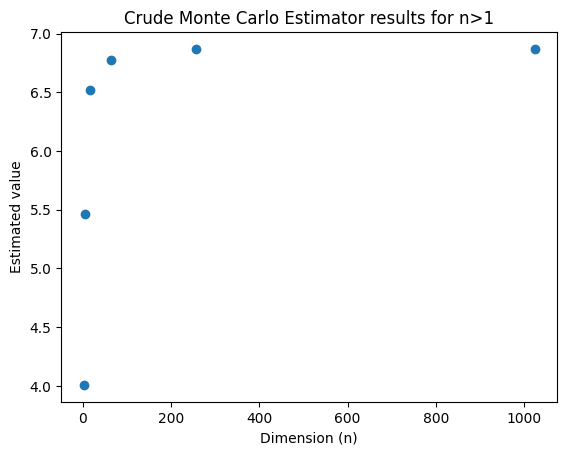

In [36]:
plt.scatter([n1, n2, n3, n4, n5, n6], ests)
plt.ylabel("Estimated value")
plt.xlabel("Dimension (n)")
plt.title("Crude Monte Carlo Estimator results for n>1")

## 3.Stratified Estimator


In [88]:
from scipy.stats import chi2
m = 10
vars = []

def stratified(S_0, n, rep, m=10):
  means = []
  sigma_m = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      sigma_m[i, j] = min(i+1, j+1) / n
  A = np.linalg.cholesky(sigma_m)
  for i in range(m):
    k = int(rep[i])  # liczebność k-tej warstwy
    ys = []
    for _ in range(k):
        z = np.random.normal(0, 1, n)
        X = z/np.linalg.norm(z)
        U = np.random.uniform(0, 1)
        D_sq = chi2.ppf(i / m + U / m, df=n)
        D = np.sqrt(D_sq)
        Z = D * X
        B = A @ Z
        S_T = S_0 * np.exp(r - (sigma**2)/2 + sigma * B[0])
        y = np.maximum(S_T - K, 0)
        ys.append(y)
    str_mean = np.mean(ys)
    means.append(str_mean)
    str_var = np.var(ys)
    vars.append(str_var)
    est_I = sum(means) * (1/m)
  return est_I

### Przypadek $n=1$ - warstwy proporcjonalne

In [103]:
Rj = [math.ceil(R/m) for i in range(m)]  # liczebność warstw

start_time = time.time()
print(stratified(S_0, 1, Rj))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

12.918725260320082
Czas wykonania: 18.788862 sekund


In [ ]:
# Przedział ufności

### Przypadek $n=1$ - warstwy optymalne

In [106]:
Rj = []  # liczebność warstw
for j in range(m):
    Rj.append((R * 1/m * np.sqrt(vars[j]))/sum((np.sqrt(vars)/m)))

start_time = time.time()
print(stratified(S_0, 1, Rj))
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

12.877350951575592
Czas wykonania: 2.421046 sekund


In [ ]:
# Przedział ufności

### Przypadek $n>1$ - warstwy proporcjonalne

In [116]:
Rj = [math.ceil(R/m) for i in range(m)]  # liczebność warstw

n1 = 2
n2 = 2**2
n3 = 2**4
n4 = 2**6
n5 = 2**8
n6 = 2**10

estss = []

In [117]:
start_time = time.time()
s = stratified(S_0, n1, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

9.074200108868643
Czas wykonania: 17.511141 sekund


In [118]:
start_time = time.time()
s = stratified(S_0, n2, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

6.514205290479808
Czas wykonania: 17.406375 sekund


In [119]:
start_time = time.time()
s = stratified(S_0, n3, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

3.7003666254928334
Czas wykonania: 20.060659 sekund


In [120]:
start_time = time.time()
s = stratified(S_0, n4, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

2.4742593351197932
Czas wykonania: 21.762766 sekund


In [121]:
start_time = time.time()
s = stratified(S_0, n5, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

1.9892612539849805
Czas wykonania: 42.843720 sekund


In [122]:
start_time = time.time()
s = stratified(S_0, n6, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

1.8998791507856354
Czas wykonania: 94.927174 sekund


Text(0.5, 1.0, 'Stratified Estimator results for n>1 (proportional)')

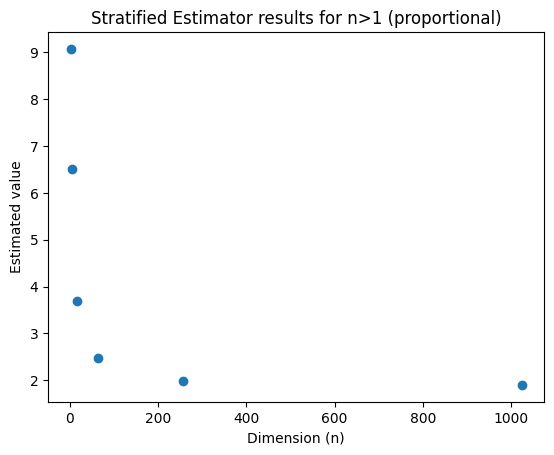

In [123]:
plt.scatter([n1, n2, n3, n4, n5, n6], estss)
plt.ylabel("Estimated value")
plt.xlabel("Dimension (n)")
plt.title("Stratified Estimator results for n>1 (proportional)")

### Przypadek $n>1$ - warstwy optymalne

In [124]:
Rj = []
for j in range(m):
    Rj.append((R * 1/m * np.sqrt(vars[j]))/sum((np.sqrt(vars)/m)))

n1 = 2
n2 = 2**2
n3 = 2**4
n4 = 2**6
n5 = 2**8
n6 = 2**10

estss = []

In [125]:
start_time = time.time()
s = stratified(S_0, n1, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

9.418262079618847
Czas wykonania: 0.951254 sekund


In [126]:
start_time = time.time()
s = stratified(S_0, n2, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

6.353234013969776
Czas wykonania: 0.985386 sekund


In [127]:
start_time = time.time()
s = stratified(S_0, n3, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

3.5912255582936456
Czas wykonania: 1.564094 sekund


In [128]:
start_time = time.time()
s = stratified(S_0, n4, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

2.507614899302178
Czas wykonania: 1.160077 sekund


In [129]:
start_time = time.time()
s = stratified(S_0, n5, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

1.9901471758237204
Czas wykonania: 2.185025 sekund


In [130]:
start_time = time.time()
s = stratified(S_0, n6, Rj)
print(s)
estss.append(s)
end_time = time.time()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

1.8978975056368683
Czas wykonania: 7.525546 sekund


Text(0.5, 1.0, 'Stratified Estimator results for n>1 (optimal)')

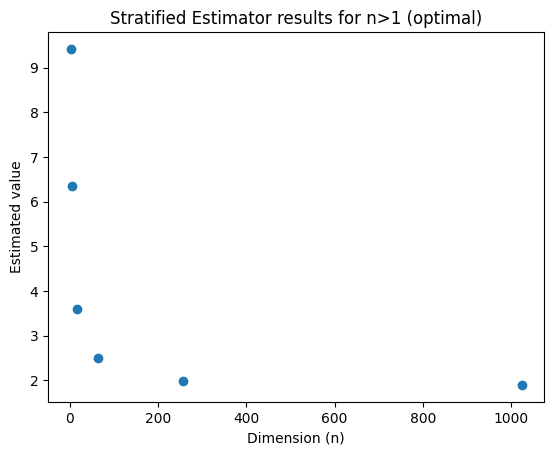

In [131]:
plt.scatter([n1, n2, n3, n4, n5, n6], estss)
plt.ylabel("Estimated value")
plt.xlabel("Dimension (n)")
plt.title("Stratified Estimator results for n>1 (optimal)")

## 4. Antithetic Estimator

### Przypadek $n=1$

In [14]:
z = np.random.normal(0, 1, int(R))
z_anty = -z  # zmienne antytetyczne
S_T = S_0 * np.exp(r - sigma**2/2 + sigma * z)  # geometryczny ruch Browna
S_T_anty = S_0 * np.exp(r - sigma**2/2 + sigma * z_anty)
y = np.maximum(S_T - K, 0)
y_anty = np.maximum(S_T - K, 0)
est_I = np.exp(-r) * (np.mean(y) + np.mean(y_anty)) / 2  # średnia

print(f"Estymowana wartość opcji to: {est_I:.4f}")

Estymowana wartość opcji to: 12.3296


In [15]:
# Przedział ufności

alpha = 0.05
vec = [i for i in y]
vec.extend(i for i in y_anty)
var_anty_cmc = np.var(vec)/R
var_anty = var_anty_cmc*(1 + np.corrcoef(S_T, S_T_anty)[0,1])
left = est_I - (sc.stats.norm.ppf(1-alpha/2) * np.sqrt(var_anty))
right = est_I + (sc.stats.norm.ppf(1-alpha/2) * np.sqrt(var_anty))
conf_interval = [left, right]
print(conf_interval)
print(f"Szerokość przedziału ufności: {right-left:.4f}")

[12.300162975703406, 12.359109194195371]
Szerokość przedziału ufności: 0.0589


In [16]:
# Błąd bezwzględny

error = np.abs(est_I - real)
print(f"Błąd bezwzględny: {error:.4f}")

Błąd bezwzględny: 0.0064


### 5. Control Variate Estimator

### Przypadek $n=1$

In [18]:
z = np.random.normal(0, 1, int(R))
S_T = S_0 * np.exp(r - sigma**2/2 + sigma * z)  # geometryczny ruch Browna
y = np.maximum(S_T - K, 0)
X = z  # zmienna kontrolna B(1), bo z ~ N(0, 1)
exp_X = 0  # znana wartość oczekiwana zmiennej B(1)
est_I_cmc = np.exp(-r) * np.mean(y)  # Y_R^{CMC} "z daszkiem", wykorzystywany we wzorze
X_R = np.mean(X)  # średnia, czyli X_R "z daszkiem"

c1 = np.cov(y, X)[0, 1]
c2 = np.var(X)
c = c1 / c2  # współczynnik c

est_I = est_I_cmc + c * (X_R - exp_X)

print(f"Estymowana wartość opcji: {est_I:.4f}")

Estymowana wartość opcji: 12.3438


In [19]:
# Przedział ufności

alpha = 0.05
var_cv_cmc = np.var(y)/R
cor = np.corrcoef(S_T, X)[0,1]
var_cv = var_cv_cmc*(1 - cor**2)
left = est_I - (sc.stats.norm.ppf(1-alpha/2) * np.sqrt(var_cv))
right = est_I + (sc.stats.norm.ppf(1-alpha/2) * np.sqrt(var_cv))
conf_interval = [left, right]
print(conf_interval)
print(f"Szerokość przedziału ufności: {right-left:.4f}")

[12.322597444793118, 12.365009369410423]
Szerokość przedziału ufności: 0.0424


In [20]:
# Błąd bezwzględny

error = np.abs(est_I - real)
print(f"Błąd bezwzględny: {error:.4f}")

Błąd bezwzględny: 0.0078
